### Natural Language Processing Assignment

#### Course: TIPP Intake 1

#### Student Name: Koay Seng Tian (sengtian@yahoo.com)

Note: by typing your full name, it is taken that you have read and understood the declaration below.

#### Declaration:

- I declare that this report is my original work. I understand that if I am suspected of plagiarism, my enrolment in the programme may be terminated.

- I declare that I have a back-up electronic copy of this report for immediate submission.


In [1]:
from datetime import datetime
from itertools import combinations
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud

import gensim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import string


In [2]:
num_topics = 19
num_top_words = 15

my_custom_stopwords = ('said', 'donald', 'clinton')

# for reproducibility, 1337 is arbitrarily set
np.random.seed(1337)

# set to True to skip the
# script to find the best topic number
SKIP = False


# Load Dataset

In [3]:
# dataset file name and its full pathname
dataset_filename = 'News Set A.csv'
dataset_dir = 'datasets'
dataset_fullpathname = os.path.join(os.getcwd(), dataset_dir)
dataset_fullpathname = os.path.join(dataset_fullpathname, dataset_filename)

# load the "News Set A.csv" as a dataframe
# and drop the first unnamed index column
df = pd.read_csv(dataset_fullpathname, encoding='utf-8', error_bad_lines=False)
df.drop(df.columns[0], axis=1)


,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...
49995,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


# Clean the Data

In [4]:
def clean_text(text):
    # change to lower case
    text = text.lower()

    # remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # remove punctuations\n",
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # remove punctuation marks specifics to this dataset
    text = re.sub(r'[—’“”]', ' ', text)
    
    # remove words less than 3 characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

def remove_custom_stopwords (str):
    #select english stopwords
    customStopWords = set(stopwords.words("english"))
    
    #add custom stop words
    customStopWords.update(my_custom_stopwords)
    
    #remove stop words
    new_str = ' '.join([word for word in str.split() if word not in customStopWords]) 
    return new_str


In [5]:
# remove custom stopwords
docs = pd.DataFrame(df.content.apply(lambda x: remove_custom_stopwords(x)))


In [6]:
# clean text
docs = pd.DataFrame(docs.content.apply(lambda x: clean_text(x)))


In [7]:
docs = docs.content.values
type(docs)
docs.shape


numpy.ndarray

(50000,)

In [8]:
# show doc #4 content
docs[4]


'seoul south korea north korea leader sunday country making final preparations conduct first test intercontinental ballistic missile bold statement less month inauguration donald trump although north korea conducted five nuclear tests last decade ballistic missile tests alone although habitually threatens attack united states nuclear weapons country never intercontinental ballistic missile icbm annual year speech broadcast north kctv sunday spoke proudly strides country made nuclear weapons ballistic missile programs north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises south korea reached final stage preparations intercontinental ballistic rocket said analysts region might conduct another weapons test coming months taking advantage leadership changes united states south korea trump sworn south korea president park whose powers suspended parliamentary impeachment waiting constitutional court rule whether formally remo

# Exploratory Data Analysis

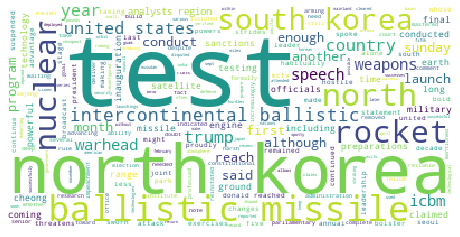

In [9]:
# generate word cloud
def showWordCloud(texts):
    words = ','.join(list(texts))
 
    # show it as wordCloud
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(words)
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud.to_image())
    
showWordCloud(docs[4].split())


In [10]:
# extracted from NLP lab exercise
# also same function can be found in scikit-learn website
def display_topic(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()


# Latent Dirichlet Allocation Analysis

In [11]:
# LDA

# create Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.9,
                             min_df=5,
                             stop_words=text.ENGLISH_STOP_WORDS.union(my_custom_stopwords),
                             lowercase=True)

data_vectorized = vectorizer.fit_transform(docs)


In [12]:
# build a LDA model

lda_model = LatentDirichletAllocation(
    n_components=num_topics,      # Number of topics
    max_iter=5,                   # Max learning iterations
    learning_method='online',   
    learning_offset=50.,
    #n_jobs=-1                    # use all available CPUs
)


In [13]:
last_time = datetime.now()

# this will take some time
lda_output = lda_model.fit_transform(data_vectorized)

past_time = datetime.now() - last_time

# model attributes
print(lda_model)

print()
print('Completed in: {}'.format(past_time))


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=19, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

Completed in: 0:15:39.355143


In [14]:
# Number of documents, Number of topics
lda_output.shape


(50000, 19)

In [15]:
# display topics
lda_feature_names = vectorizer.get_feature_names()
display_topic(lda_model, lda_feature_names, num_top_words)


Topic 0:
european europe britain migrants germany health refugees medical german british disease year people london union

Topic 1:
like world years jobs business year economic change going market make people workers time economy

Topic 2:
court state federal justice immigration states order department case legal rights government judge president attorney

Topic 3:
people like university black women school students think white make want college says know right

Topic 4:
percent health care people year state states obamacare house according million plan federal drug insurance

Topic 5:
apple company google uber like technology data amazon tech cuban castro internet cuba microsoft design

Topic 6:
border mexico united texas flight mexican wall plane airport breitbart states cartel trade agents airlines

Topic 7:
olympic world gold india olympics athletes games brazil medal australia indian sport australian team brazilian

Topic 8:
like time people years family know life told didn going s

In [16]:
# Find dominant topics for document

# Styling
def color_norm(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
    
def color_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# column names
topicnames = ["Top" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Topic'] = dominant_topic

# Apply Style to first 20 document
df_document_topic2 = df_document_topic.head(20)
#.style.applymap(color_norm).applymap(color_bold)

df_document_topic2


,Top0,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Topic
Doc0,0.00,0.03,0.32,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.12,0.00,0.00,2
Doc1,0.00,0.07,0.03,0.04,0.07,0.01,0.00,0.00,0.09,0.63,0.00,0.00,0.00,0.01,0.02,0.02,0.00,0.00,0.01,9
Doc2,0.00,0.02,0.12,0.12,0.00,0.19,0.00,0.00,0.46,0.00,0.00,0.03,0.00,0.00,0.00,0.04,0.00,0.00,0.00,8
Doc3,0.04,0.03,0.02,0.05,0.00,0.04,0.00,0.00,0.59,0.02,0.10,0.02,0.03,0.00,0.03,0.01,0.00,0.01,0.01,8
Doc4,0.00,0.03,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.74,0.00,0.00,0.08,0.11,0.02,0.00,0.00,11
Doc5,0.06,0.00,0.00,0.00,0.12,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.13,8
Doc6,0.01,0.00,0.01,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.14,0.00,0.02,0.00,0.00,11
Doc7,0.31,0.02,0.00,0.29,0.07,0.00,0.00,0.00,0.27,0.00,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0
Doc8,0.01,0.00,0.10,0.00,0.00,0.03,0.00,0.00,0.71,0.00,0.09,0.00,0.00,0.00,0.00,0.02,0.03,0.01,0.02,8
Doc9,0.06,0.00,0.00,0.04,0.10,0.01,0.03,0.00,0.57,0.00,0.00,0.00,0.01,0.02,0.00,0.12,0.00,0.00,0.04,8


In [17]:
# Use pyLDAvis to visualise topic model

# this will take some time
last_time = datetime.now()

pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.152361  0.047806       1        1  12.689603
8      0.096339  0.151271       2        1  12.485217
16     0.112640  0.045456       3        1   9.587795
3      0.185902  0.051508       4        1   8.250244
2      0.038992 -0.022280       5        1   7.529455
1      0.148851 -0.133083       6        1   6.695935
11    -0.030902 -0.072709       7        1   6.612917
9     -0.088671  0.083737       8        1   5.976548
17     0.061797  0.073426       9        1   4.920580
12    -0.093823  0.046179      10        1   4.251813
4      0.096209 -0.164688      11        1   3.854367
15    -0.138169 -0.056173      12        1   3.640934
0     -0.062848 -0.078348      13        1   3.084299
13     0.004156 -0.169397      14        1   2.645110
10    -0.001110  0.114412      15        1   2.303967
5      0.041042 -0.086336      16        1   2.090610
18    -0.100277  0.246062      17        1   1.491976
6     -0.233264 -0.153631      18        1   1.199252
7     -0.189224  0.076787      19        1   0.689379, topic_info=            Term           Freq          Total Category  logprob  loglift
47689      trump  147762.000000  147762.000000  Default  30.0000  30.0000
34963     police   30748.000000   30748.000000  Default  29.0000  29.0000
47947    twitter   25437.000000   25437.000000  Default  28.0000  28.0000
31267       news   34983.000000   34983.000000  Default  27.0000  27.0000
51223      world   26474.000000   26474.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
51126      women     568.123707   20977.196602  Topic19  -5.1678   1.3683
39870     russia     531.169116   13113.630977  Topic19  -5.2350   1.7708
8988   committee     460.092845   10030.398955  Topic19  -5.3787   1.8952
47173      track     440.723671    2485.692533  Topic19  -5.4217   3.2472
36799       race     451.276170    8473.766230  Topic19  -5.3980   2.0445

[1483 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
28        10  0.997630     abbas
82         3  0.998801    abedin
146        1  0.094547  abortion
146        4  0.012748  abortion
146        5  0.892353  abortion
...      ...       ...       ...
51728     18  0.994359      zeng
51744     18  0.997714     zetas
51764     12  0.003960      zika
51764     13  0.995683      zika
51781     11  0.997858     zinke

[5955 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 9, 17, 4, 3, 2, 12, 10, 18, 13, 5, 16, 1, 14, 11, 6, 19, 7, 8])


Completed in: 0:03:40.696512


In [18]:
# Find good model performance for LDA
# using (Perplexity and log-likelihood)

if not SKIP:
    
    last_time = datetime.now()

    kmin = 18
    kmax = 22

    topic_models = []

    # try each value of k
    for k in range(kmin, kmax+1):
        print("Applying LDA for k=%d ..." % k )
        model = LatentDirichletAllocation(
             n_components=k,               # Number of topics
             max_iter=5,                   # Max learning iterations
             learning_method='online',   
             learning_offset=50.,
             #n_jobs=-1
        )

        output = model.fit_transform(data_vectorized) 
        log_likelihood = lda_model.score(data_vectorized)
        perplexity = model.perplexity(data_vectorized)
        topic_models.append((k, model, output, log_likelihood, perplexity))

    for model in topic_models:
        print('topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f' %(model[0], model[3], model[4]))
        
    past_time = datetime.now() - last_time
    print()
    print('Completed in: {}'.format(past_time))


Applying LDA for k=18 ...
Applying LDA for k=19 ...
Applying LDA for k=20 ...
Applying LDA for k=21 ...
Applying LDA for k=22 ...
topics :  18, Log Likelihood : -122292080.44   Perplexity : 4746.37
topics :  19, Log Likelihood : -122292080.44   Perplexity : 4681.02
topics :  20, Log Likelihood : -122292080.44   Perplexity : 4649.86
topics :  21, Log Likelihood : -122292080.44   Perplexity : 4668.26
topics :  22, Log Likelihood : -122292080.44   Perplexity : 4626.27

Completed in: 1:11:28.540882


# Non-Negative Matrix Factorization (NMF)

In [19]:
# if you have a big screen, run the below to extend the cell width

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [20]:
# just to ensure that the docs hasn't been changed
print(docs[4])


seoul south korea north korea leader sunday country making final preparations conduct first test intercontinental ballistic missile bold statement less month inauguration donald trump although north korea conducted five nuclear tests last decade ballistic missile tests alone although habitually threatens attack united states nuclear weapons country never intercontinental ballistic missile icbm annual year speech broadcast north kctv sunday spoke proudly strides country made nuclear weapons ballistic missile programs north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises south korea reached final stage preparations intercontinental ballistic rocket said analysts region might conduct another weapons test coming months taking advantage leadership changes united states south korea trump sworn south korea president park whose powers suspended parliamentary impeachment waiting constitutional court rule whether formally remov

In [21]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   min_df=2,
                                   stop_words=text.ENGLISH_STOP_WORDS.union(my_custom_stopwords),
                                   max_features=1000)

tfidf = tfidf_vectorizer.fit_transform(docs)


In [22]:
nmf_model = NMF(n_components=num_topics, 
                alpha=.1,
                l1_ratio=.5,
                init="nndsvd")


In [23]:
last_time = datetime.now()

# this will take some time
nmf_output = nmf_model.fit_transform(tfidf)

past_time = datetime.now() - last_time

# model attributes
print(nmf_model)  

print()
print('Completed in: {}'.format(past_time))


NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=19, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

Completed in: 0:00:52.441873


In [24]:
nmf_output.shape


(50000, 19)

In [25]:
np.argmax(nmf_output[0])

11

In [26]:
nmf_feature_names = tfidf_vectorizer.get_feature_names()


In [27]:
display_topic(nmf_model, nmf_feature_names, num_top_words)

Topic 0:
people like think going know want really says things make right black good world thing

Topic 1:
trump president campaign republican presidential nominee election pence rally washington media white york america twitter

Topic 2:
police officers officer shooting black shot arrested suspect killed attack department video authorities incident enforcement

Topic 3:
isis islamic syria attack military syrian state forces attacks iraq terrorist group government turkey muslim

Topic 4:
sanders hillary party democratic campaign presidential bernie election voters republican candidate vote state nominee democrats

Topic 5:
border texas immigration illegal mexico immigrants mexican states agents enforcement migrants united drug wall breitbart

Topic 6:
company business million companies billion apple market year google employees industry technology insider facebook money

Topic 7:
breitbart news twitter media facebook daily follow bannon milo live conservative radio host editor social

T

In [28]:
# Find dominant topics for document
# A repeat of the above code found in LDA

# column names
topicnames = ["Top" + str(i) for i in range(nmf_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Topic'] = dominant_topic

# Apply Style to first 20 document
df_document_topic2 = df_document_topic.head(20)
#.style.applymap(color_norm).applymap(color_bold)

df_document_topic2


,Top0,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Topic
Doc0,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.01,0.00,0.06,0.00,0.00,0.01,0.00,0.0,0.00,0.00,11
Doc1,0.01,0.00,0.05,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.01,2
Doc2,0.01,0.00,0.00,0.00,0.0,0.01,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.04,0.00,0.00,0.0,0.01,0.00,13
Doc3,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.03,0.01,0.02,0.0,0.00,0.00,13
Doc4,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,10
Doc5,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.0,0.00,0.00,13
Doc6,0.00,0.01,0.00,0.01,0.0,0.00,0.00,0.0,0.0,0.01,0.05,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,10
Doc7,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.0,0.00,0.00,0
Doc8,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.03,0.00,0.01,0.0,0.00,0.00,13
Doc9,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.0,0.00,0.00,13


##### Acknowledgement:
- The script below, mostly are adapted from Derek Greene, University College Dubin
- Original source: https://github.com/derekgreene/topic-model-tutorial



In [29]:
# Apply NMF for each of these values using a for-loop
topic_models = []

kmin = 16
kmax = 28

last_time = datetime.now()

# try each value of k
for k in range(kmin, kmax+1):
    print("Applying NMF for k=%d ..." % k )
    model = NMF( init="nndsvd", n_components=k, alpha=.1, l1_ratio=.5 )   
    
    W = model.fit_transform(tfidf)
    H = model.components_  
    
    # store for later
    # tfidf never change, no need to save multiple time..
    topic_models.append((k,W,H)) 
    
past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))


Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...

Completed in: 0:11:13.273464


In [30]:
class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens
            

In [31]:
# the following script is going to take a long time
import gensim

last_time = datetime.now()

docgen = TokenGenerator(docs.tolist(), text.ENGLISH_STOP_WORDS.union(my_custom_stopwords))

# the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=300, min_count=20, sg=1)

past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))


Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...

Completed in: 0:12:23.538836


In [32]:
print("Model has %d terms" % len(w2v_model.wv.vocab))


Model has 31731 terms


In [33]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


In [34]:
def get_descriptor(terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index,:])[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
    return top_terms


In [35]:
terms = nmf_feature_names

k_values = []
coherences = []

last_time = datetime.now()

for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )
    
past_time = datetime.now() - last_time
print()
print('Completed in: {}'.format(past_time))


K=16: Coherence=0.3288
K=17: Coherence=0.3331
K=18: Coherence=0.3337
K=19: Coherence=0.3361
K=20: Coherence=0.3321
K=21: Coherence=0.3326
K=22: Coherence=0.3288
K=23: Coherence=0.3224
K=24: Coherence=0.3197
K=25: Coherence=0.3240
K=26: Coherence=0.3252
K=27: Coherence=0.3223
K=28: Coherence=0.3193

Completed in: 0:00:00.515868


In [36]:
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})


([<matplotlib.axis.XTick at 0x1c639e83848>,
 <a list of 13 Text xticklabel objects>)

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Mean Coherence')

Text(19, 0.33612159523263313, 'k=19')

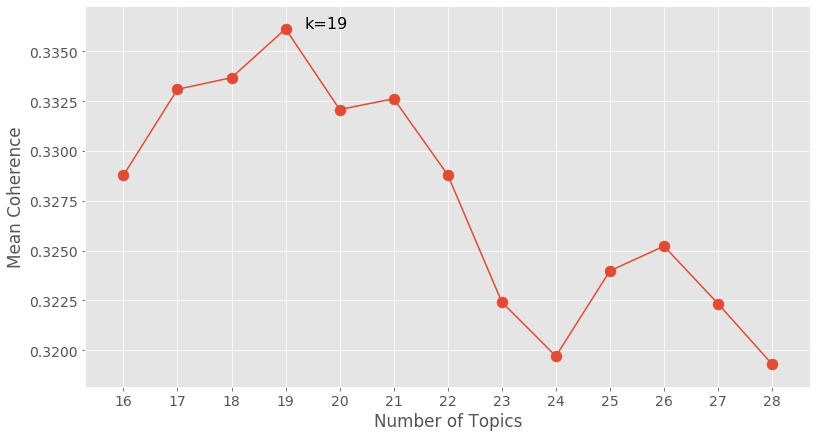

In [37]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)

# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()


In [38]:
def model_topics(model, model_name, vect, num_top_word):
    model_df = pd.DataFrame(columns=['Topic', model_name])
    
    topicList = []
    
    for _, topic in enumerate(model.components_):
        topicList.append(" ".join([vect.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    for idx, model in enumerate(topicList):
        model_df.loc[idx] = [idx] + [model]
        
    return model_df
        

In [39]:
lda_model_df = model_topics(lda_model, 'LDA', vectorizer, num_top_words)
lda_model_df


,Topic,LDA
0,0,european europe britain migrants germany healt...
1,1,like world years jobs business year economic c...
2,2,court state federal justice immigration states...
3,3,people like university black women school stud...
4,4,percent health care people year state states o...
5,5,apple company google uber like technology data...
6,6,border mexico united texas flight mexican wall...
7,7,olympic world gold india olympics athletes gam...
8,8,like time people years family know life told d...
9,9,police officers told officer city according pe...


In [40]:
nmf_model_df = model_topics(nmf_model, 'NMF', tfidf_vectorizer, num_top_words)
nmf_model_df


,Topic,NMF
0,0,people like think going know want really says ...
1,1,trump president campaign republican presidenti...
2,2,police officers officer shooting black shot ar...
3,3,isis islamic syria attack military syrian stat...
4,4,sanders hillary party democratic campaign pres...
5,5,border texas immigration illegal mexico immigr...
6,6,company business million companies billion app...
7,7,breitbart news twitter media facebook daily fo...
8,8,russia russian comey intelligence investigatio...
9,9,obama president white barack administration ho...


In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

#### Please answer the two questions in the next cell:

Question 1: Was the outcome of the topic modelling satisfactory. Why or why not ?

Below shows the topics I humanely "classified" based on the terms returned by the models.  By intuition, I tend to favour NMF as it is slightly much easy to discern the terms (by relating to the topics) returned by the model.  However, I have observed that NMF has classified a few documents as topic #0 which I disagreed.

- For example, for Doc #4, LDA classified it as topic #11 and NMF classified it as topic #10.  This I agreed
- For Doc #0, LDA classified it as topic #2 (I disagreed) and NMF classified it as topic #11 (I agreed)
- For Doc #7, I disagreed for both topic classification by LDA and NMF.

### LDA
My interpretation of the topics produced by LDA (Latent Dirichlet Allocation Analysis):

Topic #
- 0  - Health medical study
- 1  - Climate, enegegy
- 2  - America immigration
- 3  - Racial discrimination
- 4  - Amercia healthcare system
- 5  - ??
- 6  - Mexica border
- 7  - Hollywood, award
- 8  - ??
- 9  - Violence, Shooting, Polic
- 10 - Olympic, Sport, Football
- 11 - Military, China, Russia, Syria, Iran
- 12 - ISIS, Terrorists
- 13 - Company financial, Apple, Telsa
- 14 - America Election
- 15 - Weather, Forida, Storm
- 16 - America presidential election 
- 17 - ??

?? - unable to discern the topic


### NMF

My interpretation of the topics produced by LDA (Non-negative Matrix Factorization):
Topic #
- 0  - ??
- 1  - America election
- 2  - Crime, shooting, blacks
- 3  - European immigration
- 4  - Amercia Presidential election
- 5  - ISS, terrorists
- 6  - Compaines, financial status, Apple
- 7  - Twitter reportings
- 8  - Intelligence investigation
- 9  - Barack administration policy
- 10 - Defence, China, North Korea
- 11 - Health ObmaCare
- 12 - Woman, abortion, health
- 13 - Amercia polls
- 14 - Prison decision, death charges
- 15 - Games, sport
- 16 - President nomination candidate
- 17 - ??

Question 2: Which approach (LDA or NFM) works better? Why?